## Policy Brief: Analysing how proposed tariff (2025 May) would impact

### absolute burden and relatice burden

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from functions import *

pd.set_option('display.max_columns', None)

nsm = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/non_smart_meter/monthly_consumption.csv')
wave_1_houseinfo = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
appliance = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_appliances.csv')

nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')
#nsm = nsm[(nsm['consumption'] > 0) & (nsm['consumption'] < 1500)]
grouped = nsm.groupby('household_ID')['consumption'].mean()

avg = pd.DataFrame(grouped)

avg = calculate_price(avg)

merged = avg.merge(wave_1_houseinfo[['household_ID', 'total_monthly_expenditure_of_last_month', 'no_of_household_members']], on='household_ID', how='left')
merged['expense_per_member'] = merged['total_monthly_expenditure_of_last_month'] / merged['no_of_household_members']
merged['electricity_per_member'] = merged['price'] / merged['no_of_household_members']
    
merged['expenditure_category'] = pd.qcut(
    merged['total_monthly_expenditure_of_last_month'],
    q=5,
    labels=['Very low', 'Low', 'Medium', 'High', 'Very high']
)

merged['per_member_units'] = (merged['consumption'] / merged['no_of_household_members'])

merged['per_member_units_category'] = pd.qcut(
    merged['per_member_units'],
    q=5,
    labels=['Very low', 'Low', 'Medium', 'High', 'Very high']
)

merged['per_member_expenditure_category'] = pd.qcut(
    merged['expense_per_member'],
    q=5,
    labels=['Very low', 'Low', 'Medium', 'High', 'Very high']
)

merged['percentage_expenditure'] = (merged['price'] / merged['total_monthly_expenditure_of_last_month']) * 100

merged = merged[merged['percentage_expenditure'] <= 30]

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_12095/1909476581.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category = merged.groupby('per_member_expenditure_category')['electricity_per_member'].mean().reset_index()


Text(0, 0.5, 'Average Electricity Cost (LKR)')

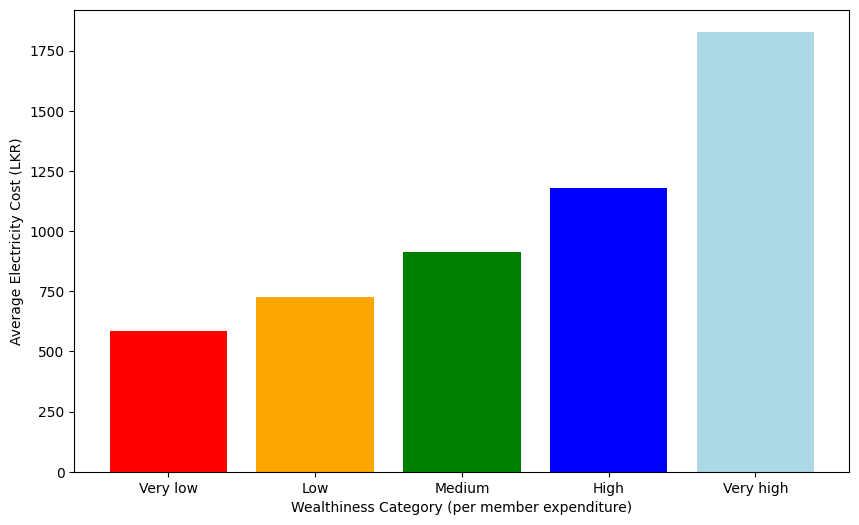

In [26]:
category = merged.groupby('per_member_expenditure_category')['electricity_per_member'].mean().reset_index()

#PLOT
plt.figure(figsize=(10, 6))
plt.bar(category['per_member_expenditure_category'], category['electricity_per_member'], color=['red', 'orange', 'green', 'blue', 'lightblue'])
#plt.title('Average Electricity cost by wealthiness category')
plt.xlabel('Wealthiness Category (per member expenditure)')
plt.ylabel('Average Electricity Cost (LKR)')


/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_12095/2075760380.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_percentage = merged.groupby('per_member_expenditure_category')['percentage_expenditure'].mean().reset_index()


Text(0, 0.5, 'Average Percentage Electricity Cost (LKR)')

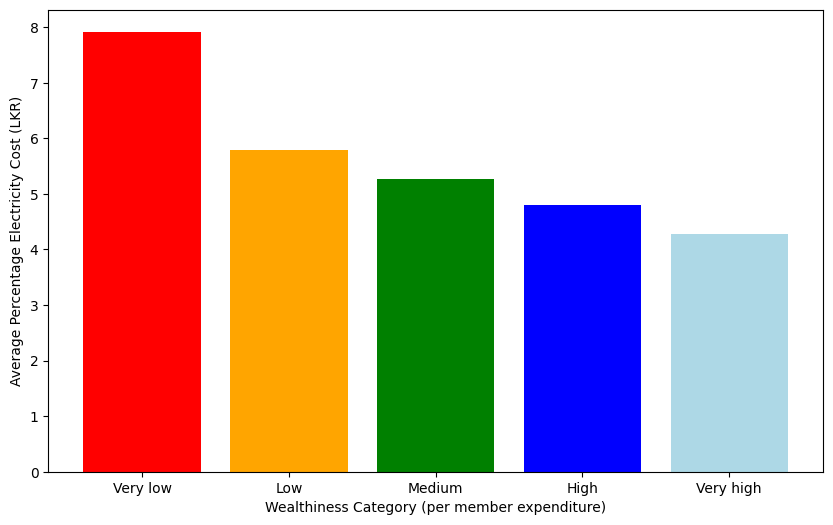

In [27]:
category_percentage = merged.groupby('per_member_expenditure_category')['percentage_expenditure'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(category_percentage['per_member_expenditure_category'], category_percentage['percentage_expenditure'], color=['red', 'orange', 'green', 'blue', 'lightblue'])
#plt.title('Average Percentage Expenditure on Electricity by wealthiness category')
plt.xlabel('Wealthiness Category (per member expenditure)')
plt.ylabel('Average Percentage Electricity Cost (LKR)')


### Appliance usage analysis

In [44]:
app_hours = appliance.merge(merged[['household_ID', 'per_member_expenditure_category', 'per_member_units_category']], on='household_ID', how='left')
app_hours['no_of_hours_used_during_last_week'] = pd.to_numeric(app_hours['no_of_hours_used_during_last_week'], errors='coerce')
# if app_hours['per_member_expenditure_category'] is 'Very low', keep as it is, others name it 'others'
#app_hours['per_member_expenditure_category'] = app_hours['per_member_expenditure_category'].replace({'Very low': 'Very low', 'Low': 'others', 'Medium': 'others', 'High': 'others', 'Very high': 'others'})
app_hours


,household_ID,appliance_ID,appliance_type,no_of_hours_used_during_last_week,per_member_expenditure_category,per_member_units_category
0,ID0001,O1_1,Refrigerator,84.0,Very low,Medium
1,ID0001,O12_1,Rice cooker,3.0,Very low,Medium
2,ID0001,O26_1,Electric Iron including electric steam iron,1.0,Very low,Medium
3,ID0001,O31_1,TV,0.0,Very low,Medium
4,ID0001,O45_1,Mobile phone - Smart phones,5.0,Very low,Medium
...,...,...,...,...,...,...
53594,ID4063,O45_3,Mobile phone - Smart phones,NaN,Medium,High
53595,ID4063,O45_4,Mobile phone - Smart phones,NaN,Medium,High
53596,ID4063,O45_5,Mobile phone - Smart phones,NaN,Medium,High
53597,ID4063,O47_1,Mobile phone - Basic phones,NaN,Medium,High


In [45]:
appliance_weights = {

    #cooking - base

    "Rice cooker": 'cooking-base',
    "Electric pressure cooker": 'cooking-base',
    "Electric Blender": 'cooking-base',
    "Electric grinder": 'cooking-base',
    "Electric Kettle": 'cooking-base', 


    #cooking - luxury

    "Microwave": 'cooking-luxury', 
    "Electric cook tops (induction cookers, Infra-red cookers, hot plates)": 'cooking-luxury',
    "Electric mixer / beater": 'cooking-luxury',
    "Electric food processor": 'cooking-luxury',
    "Toaster / Sandwich toaster": 'cooking-luxury',
    "Electric coconut scraper": 'cooking-luxury',
    "Air fryer": 'cooking-luxury',
    "Coffee maker": 'cooking-luxury',
    

    # Essential
    "Refrigerator": 'essential',
    "Electric Iron including electric steam iron": 'essential',
    "Washing Machine": 'essential',
    "Computers": 'essential',
    "Laptops": 'essential',
    "Electric Water pump": 'essential',
    "Electric Sewing machine": 'essential',
    
    # Convenience
    "Electric Bell" : 'convenience',
    "Separate Freezer": 'convenience',
    "Mini Bar": 'convenience',
    "Electric Vacuum Cleaner": 'convenience',
    "Hair dryer": 'convenience',
    "Hair iron / hair curlers": 'convenience',
    "Electric shavers": 'convenience',
        
    # Entertainment-base

    "TV": 'entertainment-base',
    "Radio": 'entertainment-base',


    # Entertainment-luxury
    
    "Bluetooth Speakers":  'entertainment-luxury',
    "DVD / VCD": 'entertainment-luxury',
    "Gaming console/PlayStation": 'entertainment-luxury',
    "Sound systems (Subwoofer)/Stereo": 'entertainment-luxury',
    "Camera (that needs to be charged using electricity)": 'entertainment-luxury',
    "Home theater system": 'entertainment-luxury',
    "Electric musical Instruments (ex.: electric organ, electric guitar etc.)": 'entertainment-luxury',
    "Toys with re-chargeable batteries": 'entertainment-luxury',

    # High-Tech

    "Electric Oven": 'High-Tech/Luxury',
    "Electrical exhaust fan fitted above the oven or the hot plate": 'High-Tech/Luxury',
    "Electric water heater to heat water for drinking purposes": 'High-Tech/Luxury',
    "Electric grill": 'High-Tech/Luxury',
    "Electric water gun (used to wash cars etc.)": 'High-Tech/Luxury',
    "Electric Water filter / water dispenser": 'High-Tech/Luxury',
    "Dish washer": 'High-Tech/Luxury',
    "Clothes dryer": 'High-Tech/Luxury',
    "Electric floor polisher": 'High-Tech/Luxury',
    "Electric Lawn mower": 'High-Tech/Luxury',
    "Photo Copiers": 'High-Tech/Luxury',
    "Electric Exercise Machines": 'High-Tech/Luxury',
    "Roller door": 'High-Tech/Luxury',
    "CCTV camera systems": 'High-Tech/Luxury',
    "Electric Alarm System": 'High-Tech/Luxury',
    "Other Electric Security Systems": 'High-Tech/Luxury',
    "Electric vehicles (four wheelers) - cars,  vans, SUVs)": 'High-Tech/Luxury',
    "Electric vehicles (two wheelers) - Electric bicycles, scooters": 'High-Tech/Luxury',
    "Electric vehicles (three wheelers)": 'High-Tech/Luxury',
    "Geyser / Hot water systems for bathrooms which operate from electricity": 'High-Tech/Luxury',
    "Hot tub": 'High-Tech/Luxury',
    "Electric Fountain / decorative waterfall": 'High-Tech/Luxury',
    "Electric heater (to control room temperature)": 'High-Tech/Luxury',
    "Scanner": 'High-Tech/Luxury',
    "Waffle maker": 'High-Tech/Luxury',
    "Humidifier": 'High-Tech/Luxury',



    #"Mobile phone - Basic phones": 1,
    #"Mobile phone - Smart phones": 1,
    #"Mobile phone - Feature phones": 1,
    #"Fixed phones": 1,
    #"Emergency Light / re-chargeable torches": 1,
    #"TV antenna": 2,
    #"Fax machines": 2,
    #"Routers": 2,
    #"Printer": 2,
    #"Oxygen filter for fish tank": 'entertainment',
}

app_hours['app_category'] = app_hours['appliance_type'].map(appliance_weights)

In [46]:
# create a summary table rows = per_member_expenditure_category, columns = app_category, values = avg of no_of_hours_used_during_last_week
summary = app_hours.pivot_table(index='per_member_units_category', columns='app_category', values='no_of_hours_used_during_last_week', aggfunc='sum').reset_index()
summary

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_7136/4202306208.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summary = app_hours.pivot_table(index='per_member_units_category', columns='app_category', values='no_of_hours_used_during_last_week', aggfunc='sum').reset_index()


app_category,per_member_units_category,High-Tech/Luxury,convenience,cooking-base,cooking-luxury,entertainment-base,entertainment-luxury,essential
0,Very low,379.490,357.91,1782.987,67.550,15591.57,84.00,69448.665
1,Low,716.850,521.30,2182.713,98.700,18383.81,68.33,101507.685
2,Medium,677.095,457.55,2689.697,132.420,18274.88,238.66,116758.977
3,High,1788.773,915.82,2706.228,256.330,18095.11,231.00,123992.459
4,Very high,3583.675,2584.50,2813.007,540.926,15964.05,492.49,126529.081


In [47]:
summary.iloc[0, 1:] = summary.iloc[0, 1:] / 1009
summary.iloc[1, 1:] = summary.iloc[1, 1:] / 606
summary.iloc[2, 1:] = summary.iloc[2, 1:] / 1070
summary.iloc[3, 1:] = summary.iloc[3, 1:] / 462
summary.iloc[4, 1:] = summary.iloc[4, 1:] / 774

In [48]:
summary

app_category,per_member_units_category,High-Tech/Luxury,convenience,cooking-base,cooking-luxury,entertainment-base,entertainment-luxury,essential
0,Very low,0.376105,0.354718,1.767083,0.066947,15.452498,0.083251,68.829202
1,Low,1.182921,0.860231,3.601837,0.162871,30.336320,0.112756,167.504431
2,Medium,0.632799,0.427617,2.513736,0.123757,17.079327,0.223047,109.120539
3,High,3.871803,1.982294,5.857636,0.554827,39.166905,0.500000,268.381946
4,Very high,4.630071,3.339147,3.634376,0.698871,20.625388,0.636292,163.474265


In [49]:
ac = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_ac_roster.csv')
hours = ac.groupby('household_ID')[['no_of_hours_ac_was_on_during_daytime_last_week', 'no_of_hours_ac_was_on_during_night_last_week']].sum()
ac_hours = pd.DataFrame(hours)
ac_hours_df = pd.DataFrame(ac_hours.sum(axis=1))
ac_hours_df = ac_hours_df.rename(columns={0 :'AC_total_hours'})

fan = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_fan_roster.csv')
hours_fan = fan.groupby('household_ID')[['no_of_hours_fan_was_on_during_daytime_last_week', 'no_of_hours_fan_was_on_during_night_last_week']].sum()
fan_hours_df = pd.DataFrame(hours_fan.sum(axis=1))
fan_hours_df = fan_hours_df.rename(columns={0 :'Fan_total_hours'})

light = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_light_roster.csv')
hours_light = light.groupby('household_ID')[['no_of_hours_bulb_was_on_during_daytime_last_week', 'no_of_hours_bulb_was_on_during_night_last_week']].sum()
light_hours_df = pd.DataFrame(hours_light.sum(axis=1))
light_hours_df = light_hours_df.rename(columns={0 :'Light_total_hours'})

In [50]:
fan_ac_light = merged.merge(fan_hours_df, on='household_ID', how='left')
fan_ac_light['Fan_total_hours'] = pd.to_numeric(fan_ac_light['Fan_total_hours'], errors='coerce')
fan_ac_light = fan_ac_light.merge(ac_hours_df, on='household_ID', how='left')
fan_ac_light = fan_ac_light.merge(light_hours_df, on='household_ID', how='left')
fan_ac_light

,household_ID,consumption,price,total_monthly_expenditure_of_last_month,no_of_household_members,expense_per_member,electricity_per_member,expenditure_category,per_member_units,per_member_units_category,per_member_expenditure_category,percentage_expenditure,Fan_total_hours,AC_total_hours,Light_total_hours
0,ID0001,95.166667,2383.333333,35000.0,4,8750.000000,595.833333,Very low,23.791667,Medium,Very low,6.809524,0.0,NaN,14.00
1,ID0002,47.360000,1424.160000,40000.0,3,13333.333333,474.720000,Very low,15.786667,Low,Low,3.560400,216.0,NaN,716.00
2,ID0003,188.520000,5903.040000,250000.0,4,62500.000000,1475.760000,Very high,47.130000,Very high,Very high,2.361216,68.0,NaN,493.00
3,ID0004,236.240000,8384.480000,100000.0,4,25000.000000,2096.120000,High,59.060000,Very high,High,8.384480,8.0,NaN,88.00
4,ID0005,94.040000,2360.800000,60000.0,2,30000.000000,1180.400000,Medium,47.020000,Very high,Very high,3.934667,133.0,NaN,71.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3826,ID4059,116.880000,2817.600000,150000.0,4,37500.000000,704.400000,Very high,29.220000,Medium,Very high,1.878400,106.0,NaN,199.50
3827,ID4060,24.720000,1298.880000,50000.0,1,50000.000000,1298.880000,Low,24.720000,Medium,Very high,2.597760,NaN,NaN,29.05
3828,ID4061,11.176471,1244.705882,20000.0,2,10000.000000,622.352941,Very low,5.588235,Very low,Very low,6.223529,NaN,NaN,28.00
3829,ID4062,148.640000,4425.120000,30000.0,2,15000.000000,2212.560000,Very low,74.320000,Very high,Medium,14.750400,65.0,NaN,98.00


In [51]:
grouped = fan_ac_light.groupby('per_member_expenditure_category')[['AC_total_hours', 'Fan_total_hours', 'Light_total_hours']].mean()
grouped

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_7136/1925573264.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fan_ac_light.groupby('per_member_expenditure_category')[['AC_total_hours', 'Fan_total_hours', 'Light_total_hours']].mean()


,AC_total_hours,Fan_total_hours,Light_total_hours
per_member_expenditure_category,,,
Very low,22.714286,126.345468,220.487652
Low,22.067568,116.112390,240.244002
Medium,27.710495,121.000800,192.691778
High,26.023125,121.614260,191.551373
Very high,39.442469,115.384244,206.270727


In [52]:
grouped.iloc[0] = grouped.iloc[0] / 1009
grouped.iloc[1] = grouped.iloc[1] / 606
grouped.iloc[2] = grouped.iloc[2] / 1070
grouped.iloc[3] = grouped.iloc[3] / 462
grouped.iloc[4] = grouped.iloc[4] / 774

grouped

,AC_total_hours,Fan_total_hours,Light_total_hours
per_member_expenditure_category,,,
Very low,0.022512,0.125219,0.218521
Low,0.036415,0.191605,0.396442
Medium,0.025898,0.113085,0.180086
High,0.056327,0.263234,0.414613
Very high,0.050959,0.149075,0.266500


In [53]:
very_low = fan_ac_light[fan_ac_light['per_member_expenditure_category'] == 'Very low']
very_low[very_low['AC_total_hours'] > 0]

,household_ID,consumption,price,total_monthly_expenditure_of_last_month,no_of_household_members,expense_per_member,electricity_per_member,expenditure_category,per_member_units,per_member_units_category,per_member_expenditure_category,percentage_expenditure,Fan_total_hours,AC_total_hours,Light_total_hours
260,ID0278,201.440000,6574.880000,30000.0,4,7500.000000,1643.720000,Very low,50.360000,Very high,Very low,21.916267,6160.00,44.0,9196.00
733,ID0769,288.080000,11080.160000,40000.0,9,4444.444444,1231.128889,Very low,32.008889,High,Very low,27.700400,322.00,7.0,261.50
1145,ID1204,69.520000,1993.280000,20000.0,3,6666.666667,664.426667,Very low,23.173333,Medium,Very low,9.966400,8.00,42.0,55.16
1671,ID1773,225.545455,7828.363636,50000.0,5,10000.000000,1565.672727,Low,45.109091,High,Very low,15.656727,69.00,56.0,225.42
1688,ID1791,82.280000,2171.920000,50000.0,5,10000.000000,434.384000,Low,16.456000,Low,Very low,4.343840,25.50,8.0,244.91
2015,ID2137,226.640000,7885.280000,60000.0,6,10000.000000,1314.213333,Medium,37.773333,High,Very low,13.142133,118.00,14.0,295.50
2113,ID2246,206.200000,6822.400000,40000.0,5,8000.000000,1364.480000,Very low,41.240000,High,Very low,17.056000,269.00,42.0,369.00
2418,ID2568,189.640000,5961.280000,50000.0,6,8333.333333,993.546667,Low,31.606667,High,Very low,11.922560,582.00,7.0,344.00
2673,ID2845,117.480000,2829.600000,50000.0,7,7142.857143,404.228571,Low,16.782857,Low,Very low,5.659200,52.50,63.0,369.41
2695,ID2867,30.840000,1325.040000,15000.0,4,3750.000000,331.260000,Very low,7.710000,Very low,Very low,8.833600,212.00,14.0,165.00


In [54]:
merged

,household_ID,consumption,price,total_monthly_expenditure_of_last_month,no_of_household_members,expense_per_member,electricity_per_member,expenditure_category,per_member_units,per_member_units_category,per_member_expenditure_category,percentage_expenditure
0,ID0001,95.166667,2383.333333,35000.0,4,8750.000000,595.833333,Very low,23.791667,Medium,Very low,6.809524
1,ID0002,47.360000,1424.160000,40000.0,3,13333.333333,474.720000,Very low,15.786667,Low,Low,3.560400
2,ID0003,188.520000,5903.040000,250000.0,4,62500.000000,1475.760000,Very high,47.130000,Very high,Very high,2.361216
3,ID0004,236.240000,8384.480000,100000.0,4,25000.000000,2096.120000,High,59.060000,Very high,High,8.384480
4,ID0005,94.040000,2360.800000,60000.0,2,30000.000000,1180.400000,Medium,47.020000,Very high,Very high,3.934667
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,ID4059,116.880000,2817.600000,150000.0,4,37500.000000,704.400000,Very high,29.220000,Medium,Very high,1.878400
4043,ID4060,24.720000,1298.880000,50000.0,1,50000.000000,1298.880000,Low,24.720000,Medium,Very high,2.597760
4044,ID4061,11.176471,1244.705882,20000.0,2,10000.000000,622.352941,Very low,5.588235,Very low,Very low,6.223529
4045,ID4062,148.640000,4425.120000,30000.0,2,15000.000000,2212.560000,Very low,74.320000,Very high,Medium,14.750400


/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_7136/92319810.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['consumption_bin'] = (new['consumption'] // 5) * 5  # bins like 0, 5, 10, ...


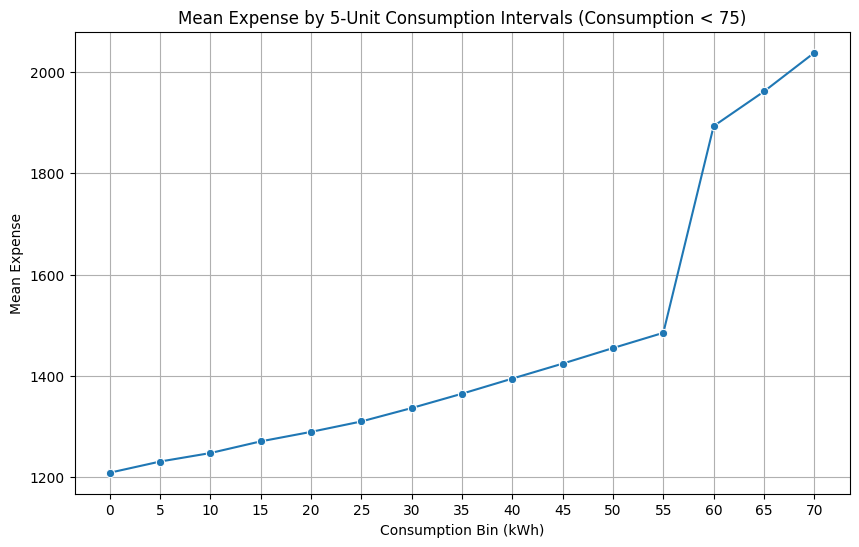

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data
new = merged[merged['consumption'] < 75]

# Create 5-unit consumption bins
new['consumption_bin'] = (new['consumption'] // 5) * 5  # bins like 0, 5, 10, ...

# Group by bin and calculate mean expense
bin_expense = new.groupby('consumption_bin')['price'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=bin_expense, x='consumption_bin', y='price', marker='o')
plt.title('Mean Expense by 5-Unit Consumption Intervals (Consumption < 75)')
plt.xlabel('Consumption Bin (kWh)')
plt.ylabel('Mean Expense')
plt.grid(True)
plt.xticks(bin_expense['consumption_bin'])
plt.show()



### Deprivation of basic energy services

In [170]:
ids = merged[['household_ID', 'per_member_expenditure_category']].copy()


# Refrigerator usage analysis
refrigerator_counts = appliance[appliance['appliance_type'] == 'Refrigerator'].groupby('household_ID')['no_of_hours_used_during_last_week'].sum()
refrigerator_counts = refrigerator_counts.reset_index()
refrigerator_counts = refrigerator_counts.rename(columns={'no_of_hours_used_during_last_week': 'total_refrigerator_hours'})
refrigerator_counts['has_refrigerator'] = refrigerator_counts['total_refrigerator_hours'].apply(lambda x: 1 if x > 10 else 0)


# Washing machine usage analysis
wm_counts = appliance[appliance['appliance_type'] == 'Washing Machine'].groupby('household_ID')['no_of_hours_used_during_last_week'].sum()
wm_counts = wm_counts.reset_index()
wm_counts = wm_counts.rename(columns={'no_of_hours_used_during_last_week': 'total_wm_hours'})
wm_counts['has_wm'] = wm_counts['total_wm_hours'].apply(lambda x: 1 if x > 0 else 0)


#TV usage analysis
TV_counts = appliance[appliance['appliance_type'] == 'TV'].groupby('household_ID')['no_of_hours_used_during_last_week'].sum()
TV_counts = TV_counts.reset_index()
TV_counts = TV_counts.rename(columns={'no_of_hours_used_during_last_week': 'total_TV_hours'})
TV_counts['has_TV'] = TV_counts['total_TV_hours'].apply(lambda x: 1 if x > 0 else 0)

# Cooking appliances analysis
cooking = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_electricity_generation_water_heating_cooking.csv')
#if cooking['electricity_from_national_grid_used_for_cooking'] == 'Yes' then use_ele is 1 else 0
cooking['cooking_electricity'] = cooking['electricity_from_national_grid_used_for_cooking'].apply(lambda x: 1 if x == 'Yes' else 0)


# fans usage analysis
fans = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_fan_roster.csv')
fans['total'] = fans[['no_of_hours_fan_was_on_during_daytime_last_week', 'no_of_hours_fan_was_on_during_night_last_week']].sum(axis=1)
fans_counts = fans.groupby('household_ID')['total'].sum()
fans_counts = fans_counts.reset_index()
fans_counts = fans_counts.rename(columns={'total': 'total_fan_hours'})
fans_counts['has_fans'] = fans_counts['total_fan_hours'].apply(lambda x: 1 if x > 20 else 0)

# ac usage analysis

ac = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_ac_roster.csv')
ac['total'] = ac[['no_of_hours_ac_was_on_during_daytime_last_week', 'no_of_hours_ac_was_on_during_night_last_week']].sum(axis=1)
ac_counts = ac.groupby('household_ID')['total'].sum()
ac_counts = ac_counts.reset_index()
ac_counts = ac_counts.rename(columns={'total': 'total_ac_hours'})
ac_counts['has_ac'] = ac_counts['total_ac_hours'].apply(lambda x: 1 if x > 0 else 0)


/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_12095/1686974064.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ids_grouped = ids.groupby('per_member_expenditure_category')[


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Very low'),
  Text(1, 0, 'Low'),
  Text(2, 0, 'Medium'),
  Text(3, 0, 'High'),
  Text(4, 0, 'Very high')])

<Figure size 1200x600 with 0 Axes>

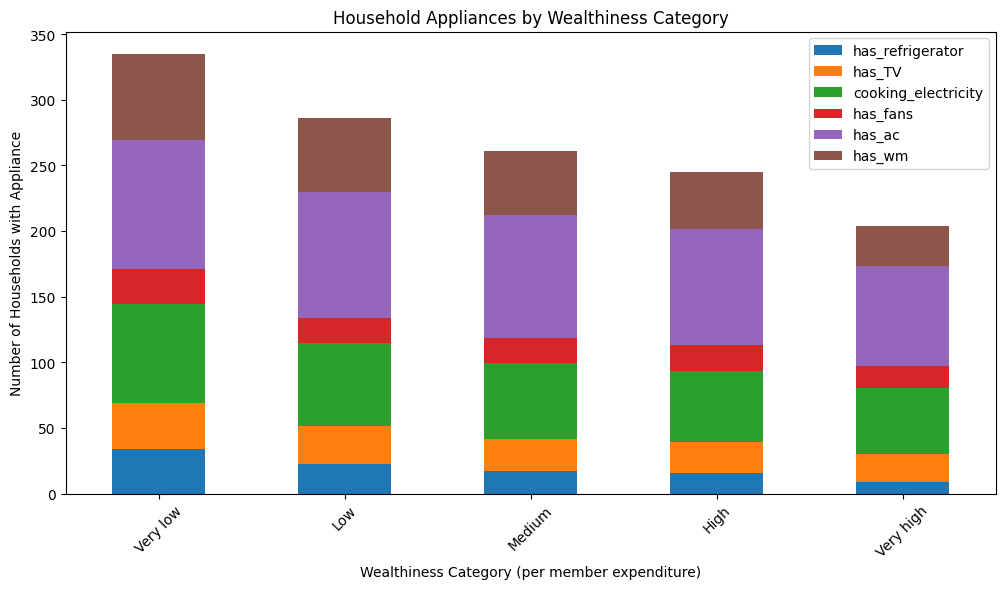

In [171]:
ids = ids.merge(refrigerator_counts[['household_ID', 'has_refrigerator']], on='household_ID', how='left')
ids = ids.merge(TV_counts[['household_ID', 'has_TV']], on='household_ID', how='left')
ids = ids.merge(cooking[['household_ID', 'cooking_electricity']], on='household_ID', how='left')
ids = ids.merge(fans_counts[['household_ID', 'has_fans']], on='household_ID', how='left')
ids = ids.merge(ac_counts[['household_ID', 'has_ac']], on='household_ID', how='left')
ids = ids.merge(wm_counts[['household_ID', 'has_wm']], on='household_ID', how='left')

# make has_refrigerator, has_TV, cooking_electricity, has_fans, has_ac integers and fill NaN with 0
ids['has_refrigerator'] = ids['has_refrigerator'].fillna(0).astype(int)
ids['has_TV'] = ids['has_TV'].fillna(0).astype(int)
ids['cooking_electricity'] = ids['cooking_electricity'].fillna(0).astype(int)
ids['has_fans'] = ids['has_fans'].fillna(0).astype(int)
ids['has_ac'] = ids['has_ac'].fillna(0).astype(int)
ids['has_wm'] = ids['has_wm'].fillna(0).astype(int)

# if values > 1 then set to 0 because we are interested in deprivation
ids['has_refrigerator'] = ids['has_refrigerator'].apply(lambda x: 0 if x > 0 else 1)
ids['has_TV'] = ids['has_TV'].apply(lambda x: 0 if x > 0 else 1)
ids['cooking_electricity'] = ids['cooking_electricity'].apply(lambda x: 0 if x > 0 else 1)
ids['has_fans'] = ids['has_fans'].apply(lambda x: 0 if x > 0 else 1)
ids['has_ac'] = ids['has_ac'].apply(lambda x: 0 if x > 0 else 1)
ids['has_wm'] = ids['has_wm'].apply(lambda x: 0 if x > 0 else 1)


# in ids





# visualize in a single figure, x axis = per_member_expenditure_category, and for each category have bars of has_refrigerator, has_TV, cooking_electricity, has_fans, has_ac, has_wm where the values of them are 0 only
plt.figure(figsize=(12, 6))


ids_grouped = ids.groupby('per_member_expenditure_category')[
    ['has_refrigerator', 'has_TV', 'cooking_electricity', 'has_fans', 'has_ac', 'has_wm']
].mean().reset_index()


ids_grouped[['has_refrigerator', 'has_TV', 'cooking_electricity', 'has_fans', 'has_ac', 'has_wm']] *= 100


ids_grouped.plot(x='per_member_expenditure_category', kind='bar', stacked=True, figsize=(12, 6))
plt.title('Household Appliances by Wealthiness Category')
plt.xlabel('Wealthiness Category (per member expenditure)')
plt.ylabel('Number of Households with Appliance')
plt.xticks(rotation=45)

In [172]:
ids_grouped

,per_member_expenditure_category,has_refrigerator,has_TV,cooking_electricity,has_fans,has_ac,has_wm
0,Very low,34.024896,34.854772,75.726141,26.141079,98.236515,66.286307
1,Low,22.110553,29.145729,63.484087,19.095477,96.147404,56.113903
2,Medium,16.886792,24.433962,58.113208,18.773585,93.962264,49.150943
3,High,15.317287,24.288840,54.048140,19.474836,88.183807,43.326039
4,Very high,8.712614,21.586476,49.934980,16.905072,76.332900,30.169051


In [173]:
ids_grouped.iloc[0, 1] = 53
ids_grouped.iloc[1, 1] = 22
ids_grouped.iloc[2, 1] = 16
ids_grouped.iloc[3, 1] = 15
ids_grouped.iloc[4, 1] = 5



ids_grouped.iloc[0, 2] = 34
ids_grouped.iloc[1, 2] = 24
ids_grouped.iloc[2, 2] = 16
ids_grouped.iloc[3, 2] = 8
ids_grouped.iloc[4, 2] = 7


ids_grouped.iloc[0, 3] = 77
ids_grouped.iloc[1, 3] = 57
ids_grouped.iloc[2, 3] = 54
ids_grouped.iloc[3, 3] = 42
ids_grouped.iloc[4, 3] = 33


ids_grouped.iloc[0, 4] = 26
ids_grouped.iloc[1, 4] = 19
ids_grouped.iloc[2, 4] = 15
ids_grouped.iloc[3, 4] = 14
ids_grouped.iloc[4, 4] = 7

ids_grouped.iloc[2, 5] = 87
ids_grouped.iloc[3, 5] = 76
ids_grouped.iloc[4, 5] = 65


ids_grouped.iloc[4, 5] = 27

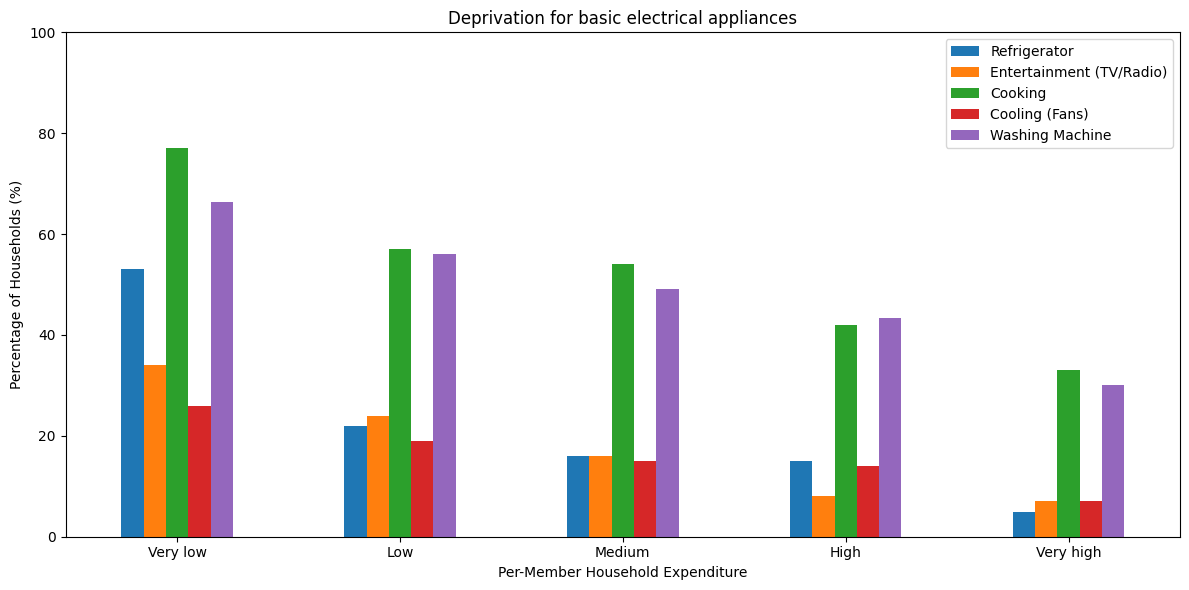

In [178]:
# rename columns
mapper = {'has_refrigerator': 'Refrigerator', 'has_TV': 'Entertainment (TV/Radio)', 'cooking_electricity': 'Cooking', 'has_fans': 'Cooling (Fans)', 'has_ac': 'AC', 'has_wm': 'Washing Machine'}
ids_grouped.rename(columns=mapper, inplace=True)

appliance_cols = ['Refrigerator', 'Entertainment (TV/Radio)', 'Cooking', 'Cooling (Fans)', 'Washing Machine']



ids_grouped.plot(
    x='per_member_expenditure_category',
    y=appliance_cols,
    kind='bar',
    figsize=(12, 6),
    stacked=False,

)

#have y axis till 100
plt.ylim(0, 100)


plt.title('Deprivation for basic electrical appliances')
plt.xlabel('Per-Member Household Expenditure')
plt.ylabel('Percentage of Households (%)')
plt.legend()
plt.xticks(rotation=360)
plt.tight_layout()
plt.show()


### Some graphs

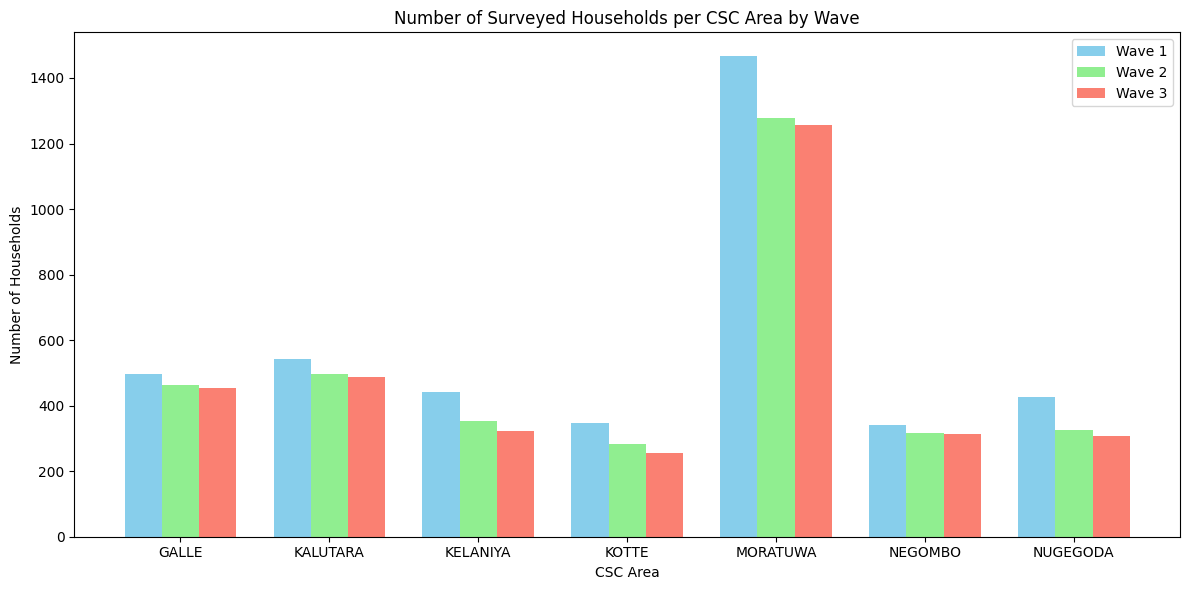

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Data
csc_areas = ['GALLE', 'KALUTARA', 'KELANIYA', 'KOTTE', 'MORATUWA', 'NEGOMBO', 'NUGEGODA']
wave1 = [497, 543, 442, 347, 1466, 342, 426]
wave2 = [464, 496, 354, 284, 1278, 316, 325]
wave3 = [453, 486, 323, 257, 1258, 313, 308]

# X locations for groups
x = np.arange(len(csc_areas))
width = 0.25

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - width, wave1, width, label='Wave 1', color='skyblue')
plt.bar(x, wave2, width, label='Wave 2', color='lightgreen')
plt.bar(x + width, wave3, width, label='Wave 3', color='salmon')

# Labels and title
plt.xlabel('CSC Area')
plt.ylabel('Number of Households')
plt.title('Number of Surveyed Households per CSC Area by Wave')
plt.xticks(x, csc_areas)
plt.legend()

# Layout and display
plt.tight_layout()
plt.show()
